In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import backtrader as bt
from datetime import datetime
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

In [99]:
tsmc_data = yf.download("NXPI", start='2021-01-01')
soxx_data = yf.download("SOXX", start='2021-01-01')
tsmc_data

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,160.330002,165.839996,158.619995,162.039993,160.681473,2931600
2021-01-05,161.529999,165.970001,161.119995,165.669998,164.281052,1980600
2021-01-06,164.610001,171.800003,164.610001,168.720001,167.305481,2686500
2021-01-07,172.089996,176.500000,171.929993,174.990005,173.522903,2485500
2021-01-08,181.380005,182.550003,171.500000,175.029999,173.562576,2827900
...,...,...,...,...,...,...
2021-11-23,221.410004,224.089996,215.570007,219.119995,219.119995,2070000
2021-11-24,216.600006,221.220001,214.320007,221.029999,221.029999,1630900
2021-11-26,213.119995,217.559998,210.250000,212.449997,212.449997,1776500


In [100]:
qcom_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-01-04,381.640015,389.779999,374.859985,377.589996,375.511932,829200
2021-01-05,377.290009,385.309998,377.000000,385.309998,383.189453,556900
2021-01-06,381.100006,391.609985,380.570007,384.059998,381.946320,1071700
2021-01-07,389.679993,399.529999,389.679993,398.549988,396.356598,603000
2021-01-08,404.260010,406.109985,394.079987,398.760010,396.565460,706600
...,...,...,...,...,...,...
2021-11-23,529.349976,532.909973,518.919983,527.789978,527.789978,807600
2021-11-24,523.650024,533.859985,518.409973,533.590027,533.590027,705700
2021-11-26,523.520020,528.260010,514.919983,518.739990,518.739990,816000


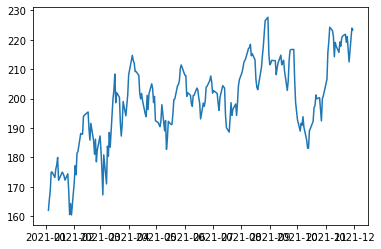

In [101]:
plt.plot(tsmc_data["Close"])

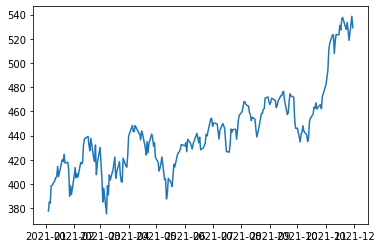

In [102]:
plt.plot(soxx_data["Close"])

In [103]:
correlation = tsmc_data["Close"].corr(soxx_data["Close"])
correlation

0.7995789138798308

In [105]:
adfuller(tsmc_data["Close"])

(-2.7961821710312424,
 0.058821190619362515,
 2,
 227,
 {'1%': -3.4594900381360034,
  '5%': -2.8743581895178485,
  '10%': -2.573601605503697},
 1258.550330362581)

In [115]:
z_score = sm.OLS(tsmc_data["Close"], soxx_data["Close"])
z_score